In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
import cv2

import common.loss_utils as loss_utils


In [3]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [4]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [5]:
def check_times(tstart, tend):
    # check_times(times[0], times[35])
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

In [6]:

class DataFetcher:
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
#         rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
#         rand_y = self.generator.randint(0, input_slice.shape[1] - 128)
        rand_x = (input_slice.shape[2] - 128) // 2
        rand_y = (input_slice.shape[1] - 128) // 2

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = DataFetcher(times, data)

In [7]:
np.random.seed(7)
indices = np.arange(len(ds))
np.random.shuffle(indices)

In [8]:
x, y = ds[0]

In [9]:
x.shape, y.shape

((12, 128, 128), (24, 64, 64))

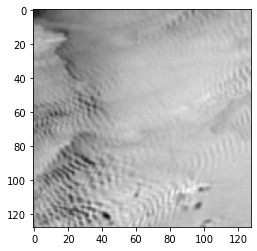

In [10]:
plt.imshow(x[0], cmap='gray')

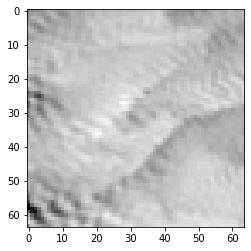

In [11]:
plt.imshow(y[0], cmap='gray')

In [12]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return res

def get_mssim(y, x):
    if len(y.shape) == 2:
        # we need to specify a number of channels. This sets it to 1 and calls the function again
        return get_mssim(np.expand_dims(y, 0), np.expand_dims(x, 0))
    if len(y.shape) == 4:
        y = y.reshape(-1, y.shape[2], y.shape[3])
        x = x.reshape(-1, x.shape[2], x.shape[3])
    assert len(y.shape) == 3
    mssim_loss = loss_utils.MS_SSIMLoss(data_range=1023, channels=y.shape[0])
    yd = np.expand_dims(y, 0) # /255 * (MAX - MIN) + MIN
    xd = np.expand_dims(x, 0) # /255 * (MAX - MIN) + MIN
    return 1.0 - mssim_loss(
        torch.Tensor(yd),
        torch.Tensor(xd),
    ).item()

In [13]:
LOOKS = 500


In [61]:
pers_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    preds = x[-1:,32:96,32:96]
    preds = np.tile(preds, (y.shape[0], 1, 1))
    score = get_mssim(preds, y)
    pers_scores.append(score)

100%|██████████| 1500/1500 [00:08<00:00, 172.47it/s]


In [62]:
np.mean(pers_scores)

0.6125835330088933

In [169]:
optical_flow_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    flow = cv2.calcOpticalFlowFarneback(
        prev=x[-2],
        next=x[-1],
        flow=None,
        pyr_scale=0.5, levels=3, winsize=15, 
        iterations=10, poly_n=5, poly_sigma=1.2, 
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
    )
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(24):
        cur = warp_flow(cur, flow)
        preds[j] = cur[32:96,32:96]
    
    score = get_mssim(preds, y)
    optical_flow_scores.append(score)


100%|██████████| 1000/1000 [00:17<00:00, 58.41it/s]


In [170]:
np.mean(optical_flow_scores)

0.6615604169368744

In [14]:
def score_optical_flow_params(forecast=24, verbose=False, **params):
    running_total = 0
    iterable = tqdm.tqdm(range(LOOKS)) if verbose else range(LOOKS)
    for i in iterable:
        x, y = ds[indices[i]]
        flow = cv2.calcOpticalFlowFarneback(
            prev=x[-2],
            next=x[-1],
            flow=None,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
            **params,
        )
        cur = x[-1].astype(np.float32)
        preds = np.zeros(y.shape, dtype=np.float32)
        for j in range(forecast):
            cur = warp_flow(cur, flow)
            # AN OPTIMIZATION
            cur = cv2.blur(cur, (3, 3))
            preds[j] = cur[32:96,32:96]
        remaining = 24 - forecast
        # just propogate the final prediction
        if remaining > 0:
            preds[forecast:] = cur[32:96,32:96]
        running_total += get_mssim(preds, y)
    return running_total / LOOKS

In [14]:
def score_weighted_optical_flow_params(w1, w2, forecast=24, verbose=False, **params):
    # normalize the weights to sum to 1
    sm = w1 + w2
    w1 = w1/sm
    w2 = w2/sm
    
    running_total = 0
    iterable = tqdm.tqdm(range(LOOKS)) if verbose else range(LOOKS)
    for i in iterable:
        x, y = ds[indices[i]]
        flow2 = cv2.calcOpticalFlowFarneback(
            prev=x[-3],
            next=x[-2],
            flow=None,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
            **params,
        )
        flow1 = cv2.calcOpticalFlowFarneback(
            prev=x[-2],
            next=x[-1],
            flow=None,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
            **params,
        )
        flow = flow1*w1 + flow2*w2
        cur = x[-1]
        preds = np.zeros(y.shape, dtype=np.float32)
        for j in range(forecast):
            cur = warp_flow(cur, flow)
            preds[j,:,:] = cur[32:96,32:96]
        remaining = 24 - forecast
        # just propogate the final prediction
        if remaining > 0:
            preds[forecast:] = cur[32:96,32:96]
        running_total += get_mssim(preds, y)
    return running_total / LOOKS

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [16]:
def objective(params):
    # negative cause minimize
#     return -score_weighted_optical_flow_params(**params)
    return -score_optical_flow_params(**params)

In [17]:
space = dict(
#     w1=hp.uniform('w1', 0.0, 1.0),
#     w2=hp.uniform('w2', 0.0, 1.0),
    forecast=hp.uniformint('forecast', 1, 24),
    pyr_scale=hp.uniform('pyr_scale', 0.0, 1.0), 
    levels=hp.uniformint('levels', 1, 10),
    winsize=hp.uniformint('winsize', 1, 20),
    iterations=hp.uniformint('iterations', 1, 20),
    poly_n=hp.uniformint('poly_n', 1, 10),
    poly_sigma=hp.uniform('poly_sigma', 0.0, 2.5)
)

In [18]:
trials = Trials()

In [19]:
best = fmin(
    objective,
    space,
    algo=tpe.suggest,
    max_evals=5000,
    trials=trials,
    trials_save_file='trials_1flow.joblib',
)

100%|██████████| 5000/5000 [7:47:29<00:00,  5.61s/trial, best loss: -0.6959038256406784]  


In [20]:
trials.best_trial['misc']['vals']

{'forecast': [24.0],
 'iterations': [1.0],
 'levels': [10.0],
 'poly_n': [2.0],
 'poly_sigma': [1.3358462139572997],
 'pyr_scale': [0.13581496550086464],
 'winsize': [3.0]}

In [47]:
not_int = ['pyr_scale', 'poly_sigma']

d = dict()
for k, v in trials.best_trial['misc']['vals'].items():
    if k in not_int:
        d[k] = v[0]
    else:
        d[k] = int(v[0])
    

In [48]:
d

{'forecast': 24,
 'iterations': 1,
 'levels': 10,
 'poly_n': 2,
 'poly_sigma': 0.5048893672455674,
 'pyr_scale': 0.09037566707105688,
 'winsize': 2}

In [401]:
score_optical_flow_params(**d)

0.6375559419393539